## Recommender Systems

In [50]:
#NETFLIX REAL 50.000.000 usuaris and 100.000 items
%autosave 150
%matplotlib inline
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from scipy import sparse
import random


# Load Data set
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('/Users/kasia/Desktop/recsysMaster2020-master/data/ml-1m/users.dat', sep='::', names=u_cols)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('/Users/kasia/Desktop/recsysMaster2020-master/data/ml-1m/ratings.dat', sep='::', names=r_cols)

# the movies file contains columns indicating the movie's genres
# let's only load the first three columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date']
movies = pd.read_csv('/Users/kasia/Desktop/recsysMaster2020-master/data/ml-1m/movies.dat', sep='::', names=m_cols, usecols=range(3), encoding='latin-1')

# Construcció del DataFrame
data = pd.merge(pd.merge(ratings, users), movies)
data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]


print("La BD has "+ str(data.shape[0]) +" ratings")
print("La BD has ", data.user_id.nunique()," users")
print("La BD has ", data.movie_id.nunique(), " movies")
data.head()


## Divide the data in two sets: training and test
def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.2)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    return df

data['for_testing'] = False
grouped = data.groupby('user_id', group_keys=False).apply(assign_to_set)
data_train = data[grouped.for_testing == False]
data_test = data[grouped.for_testing == True]
print(data_train.shape)
print(data_test.shape)
print(data_train.index & data_test.index)

print("Training data_set has "+ str(data_train.shape[0]) +" ratings")
print("Test data set has "+ str(data_test.shape[0]) +" ratings")
print("La BD has ", data.movie_id.nunique(), " movies")

Autosaving every 150 seconds


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


La BD has 1000209 ratings
La BD has  6040  users
La BD has  3706  movies
(797758, 8)
(202451, 8)
Int64Index([], dtype='int64')
Training data_set has 797758 ratings
Test data set has 202451 ratings
La BD has  3706  movies


In [51]:
dataSmall = data[data['movie_id']<600] # get only data from 100 users
print(dataSmall.shape)

dataSmall.loc[:,'for_testing'] = False
grouped = dataSmall.groupby('movie_id', group_keys=False).apply(assign_to_set)
dataSmall_train = dataSmall[grouped.for_testing == False]
dataSmall_test = dataSmall[grouped.for_testing == True]

print(dataSmall_train.shape )
print(dataSmall_test.shape )

print('Usuaris:', dataSmall.user_id.nunique() )
print('Films:',dataSmall.movie_id.nunique() )

(171560, 8)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


(137008, 8)
(34552, 8)
Usuaris: 5952
Films: 586


## 2. Functions

In [15]:
import turicreate
from turicreate import SArray

def compute_precision_recall(y_pred, y_true):
    y_true = SArray(y_true, dtype = int)
    y_pred = SArray(y_pred, dtype = int)
    
    pr_score = turicreate.evaluation.precision(y_pred, y_true)
    rec_score = turicreate.evaluation.recall(y_pred, y_true)
    return(pr_score,rec_score)

In [16]:
def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

In [17]:
def evaluate_PR(estimate_f,data_train,data_test):
    """ RMSE-based predictive performance evaluation with pandas. """
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    estimated = np.array([estimate_f(u,i) if u in data_train.movie_id else 3 for (u,i) in ids_to_estimate ])
    real = data_test.rating.values
    return compute_precision_recall(estimated, real)

In [18]:
def evaluate_RMSE(estimate_f,data_train,data_test):
    """ RMSE-based predictive performance evaluation with pandas. """
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    estimated = np.array([estimate_f(u,i) if u in data_train.movie_id else 3 for (u,i) in ids_to_estimate ])
    real = data_test.rating.values
    return compute_rmse(estimated, real)

## 3.  Exploratory Data Analysis

In [7]:
data.describe()

,user_id,movie_id,rating,sex
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,2.973831e+01
std,1.728413e+03,1.096041e+03,1.117102e+00,1.175198e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.506000e+03,1.030000e+03,3.000000e+00,2.500000e+01
50%,3.070000e+03,1.835000e+03,4.000000e+00,2.500000e+01
75%,4.476000e+03,2.770000e+03,4.000000e+00,3.500000e+01
max,6.040000e+03,3.952000e+03,5.000000e+00,5.600000e+01


### 10 the most rated movies

In [52]:
most_rated = data.groupby('title').size().sort_values(ascending=False)[:10]
most_rated

title
American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
Saving Private Ryan (1998)                               2653
Terminator 2: Judgment Day (1991)                        2649
Matrix, The (1999)                                       2590
Back to the Future (1985)                                2583
Silence of the Lambs, The (1991)                         2578
dtype: int64

### 10 movies with the higest  mean score that have been rated at least 100 times.

In [53]:
movie_stats = data.groupby('title').agg({'rating': [np.size, np.mean]})
atleast_100 = movie_stats['rating']['size'] >= 100
movie_stats[atleast_100].sort_values([('rating', 'mean')], ascending=False)[:10]

rating          
                                                     size      mean
title                                                              
Seven Samurai (The Magnificent Seven) (Shichini...    628  4.560510
Shawshank Redemption, The (1994)                     2227  4.554558
Godfather, The (1972)                                2223  4.524966
Close Shave, A (1995)                                 657  4.520548
Usual Suspects, The (1995)                           1783  4.517106
Schindler's List (1993)                              2304  4.510417
Wrong Trousers, The (1993)                            882  4.507937
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)         470  4.491489
Raiders of the Lost Ark (1981)                       2514  4.477725
Rear Window (1954)                                   1050  4.476190

### 10 movies with the highest score

In [54]:
high_score = data_train.groupby('title').rating.mean().sort_values(ascending=False).head(10)
high_score

title
Smashing Time (1967)                   5.00
Song of Freedom (1936)                 5.00
Gate of Heavenly Peace, The (1995)     5.00
Lured (1947)                           5.00
Bittersweet Motel (2000)               5.00
Baby, The (1973)                       5.00
One Little Indian (1973)               5.00
Lamerica (1994)                        5.00
I Am Cuba (Soy Cuba/Ya Kuba) (1964)    4.80
Seven Chances (1925)                   4.75
Name: rating, dtype: float64

### Distribution of ratings 

In [56]:
rating = pd.DataFrame(data.groupby('title')['rating'].mean())

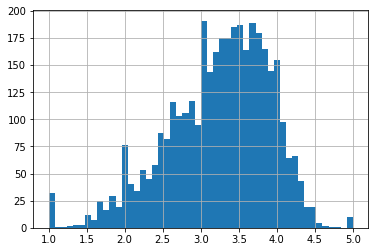

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
rating['rating'].hist(bins=50)

### Frequency of ratings

Text(0.5, 1.0, 'Frequency of ratings')

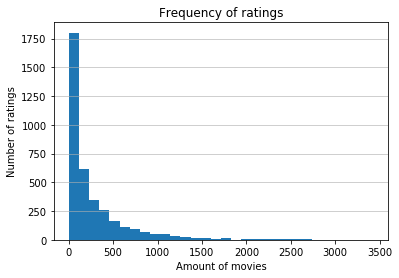

In [61]:
rating['number_of_ratings'] = data.groupby('title')['rating'].count()
plt.hist(rating['number_of_ratings'],bins=30)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Amount of movies')
plt.ylabel('Number of ratings')
plt.title('Frequency of ratings')

From the diagram below we can see that their is a positive relationship between the average rating of a movie and the number of ratings

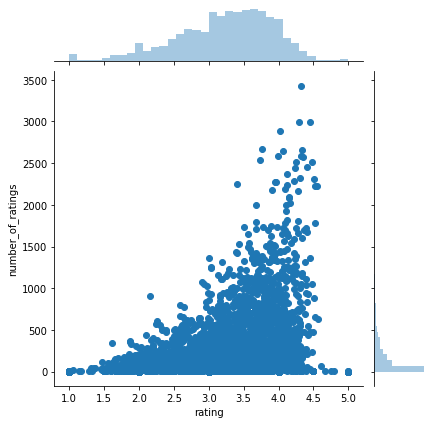

In [62]:
import seaborn as sns
sns.jointplot(x='rating', y='number_of_ratings', data=rating)

### Movie release time

Text(0, 0.5, 'Amount of movies')

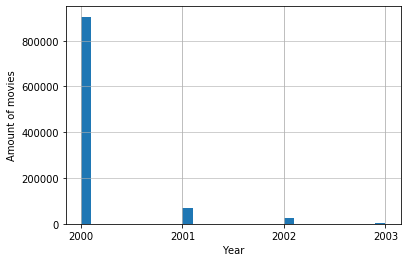

In [63]:
import time
ratings['timestamp'] = ratings['unix_timestamp'].apply(lambda x: time.strftime('%Y', time.localtime(x)))
ratings['timestamp'].hist(bins=30)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Year')
plt.ylabel('Amount of movies')

Most of the movies was released in 2000.

### Genres

In [64]:
#define a function that counts the number of times each genre appear:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [65]:
#here we  make census of the genres:
genre_labels = set()
for s in movies['release_date'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))


In [66]:
#counting how many times each of genres occur:
keyword_occurences, dum = count_word(movies, 'release_date', genre_labels)
keyword_occurences

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471],
 ['Horror', 343],
 ['Adventure', 283],
 ['Sci-Fi', 276],
 ["Children's", 251],
 ['Crime', 211],
 ['War', 143],
 ['Documentary', 127],
 ['Musical', 114],
 ['Mystery', 106],
 ['Animation', 105],
 ['Western', 68],
 ['Fantasy', 68],
 ['Film-Noir', 44]]

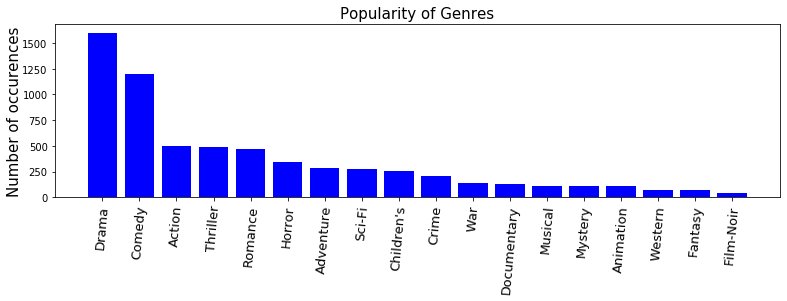

In [67]:
trunc_occurences = keyword_occurences[0:50]
fig = plt.figure(1, figsize=(13,7))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 13)
plt.xticks(x_axis, x_label)
plt.ylabel("Number of occurences", fontsize = 15, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='b')
plt.title("Popularity of Genres",fontsize = 15)
plt.show()

## 4. CollaborativeFiltering - Item Based

In [68]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

class CollaborativeFiltering:
    """ Collaborative filtering using a custom sim(u,u'). """
    
    def __init__(self, DataFrame):
        """ Constructor """
        
        self.df=DataFrame       
        self.pivot = pd.pivot_table(DataFrame, index='movie_id', columns='user_id', values='rating')     
        self.pivot_norm = self.pivot.apply(lambda x: x - np.nanmean(x), axis=1)    
        self.pivot_norm.fillna(0, inplace=True) 
        #self.item_sim_df = pd.DataFrame(cosine_similarity(self.pivot_norm, self.pivot_norm), index=self.pivot_norm.index, columns=self.pivot_norm.index)
        #print( self.item_sim_df)      
        self.item_sim_df = pd.DataFrame(1-pairwise_distances(self.pivot_norm, self.pivot_norm, metric = 'correlation'), index=self.pivot_norm.index, columns=self.pivot_norm.index)

        
    def learn(self, movie_id):
        
        if movie_id not in self.pivot_norm.index:
            return None, None
        else:  
            sim_movies = self.item_sim_df.sort_values(by=movie_id, ascending=False).index[1:]
            sim_score = self.item_sim_df.sort_values(by=movie_id, ascending=False).loc[:, movie_id].tolist()[1:]
            return sim_movies, sim_score
    
    # predict the rating of anime x by user y
    def estimate(self, user_id, movie_id, max_neighbor=10):
        movies, scores = self.learn(movie_id) 
        movie_arr = np.array([x for x in movies])
        sim_arr = np.array([x for x in scores])

    
    # select only the anime that has already rated by user x
        filtering = self.pivot_norm[user_id].loc[movie_arr] != 0
    
    # calculate the predicted score
        score = np.dot(sim_arr[filtering][:max_neighbor], self.pivot[user_id].loc[movie_arr[filtering][:max_neighbor]]) \
                / np.sum(sim_arr[filtering][:max_neighbor])
        
        return score
    
    

In [69]:
reco_IB = CollaborativeFiltering(dataSmall_train)
reco_IB.estimate(3, 2)

4.000029920251232

## 4.1 Precision & Recall

In [70]:
PR_IB = evaluate_PR(reco_IB.estimate, dataSmall_train, dataSmall_test) 

In [71]:
PR_IB

(0.2, 0.2699120166705256)

## 4.2 RMSE

In [26]:
RMSE_IB = evaluate_RMSE(reco_IB.estimate, dataSmall_train, dataSmall_test)

In [72]:
RMSE_IB

1.2557577511290632

## 5.CollaborativeFiltering - Factorization 

In [30]:
class SVD_CollaborativeFiltering:
    """ Collaborative filtering using a custom sim(u,u'). """
    
    def __init__(self,DataFrame, num_components=10,
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0):
        """ Constructor """
        self.df = DataFrame
        self.num_components = num_components
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        
        urm = pd.pivot_table(self.df[['user_id','movie_id','rating']],columns='movie_id',index='user_id',values='rating',fill_value=0)
        self.n_users, self.n_items = urm.shape
        self.ratings = np.float32(urm.values)
        
        user_index = np.arange(len(urm.index))
        self.users = dict(zip(user_index,urm.index ))
        self.users_index2id = dict(zip(urm.index,user_index)) 
        
        movie_index = np.arange(len(urm.columns))
        self.movies = dict(zip(movie_index,urm.columns ))   
        self.movies_index2id = dict(zip(urm.columns, movie_index))

        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
    
    def __sdg__(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            user_id = self.users[u]
            item_id = self.movies[i]
            
            prediction = self.estimate(user_id, item_id)
            error = (self.ratings[u,i] - prediction) # error
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (error * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (error * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
                
                
    def learn(self,n_iter = 10, learning_rate=0.001):
        """ Train the model. """
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        
        # initialize latent vectors
        self.user_vecs = np.random.normal(scale=1./self.num_components,\
                                          size=(self.n_users, self.num_components))
        self.item_vecs = np.random.normal(scale=1./self.num_components,
                                          size=(self.n_items, self.num_components))

        self.learning_rate = learning_rate
        
        ctr =1
        while ctr <= n_iter:
            if ctr % 1 == 0:
                print('Iteration: {}'.format(ctr))
            self.training_indices = np.arange(self.n_samples)
            #shuffle training samples
            np.random.shuffle(self.training_indices)
            self.__sdg__()
            ctr += 1
    
                
    def estimate(self, user_id, movie_id):
        """ Single user and item prediction."""
        u = self.users_index2id[user_id]
        i = self.movies_index2id[movie_id]
        prediction =  self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        return prediction
    

In [31]:
reco_SVD = SVD_CollaborativeFiltering(dataSmall_train, num_components=40)
reco_SVD.learn()
reco_SVD.estimate(5, 2)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


1.3378986466964535

## 5.1 Pecision & Recall

In [32]:
PR_SVD = evaluate_PR(reco_SVD.estimate, dataSmall_train, dataSmall_test)

In [33]:
PR_SVD

(0.2, 0.26313961565177124)

## 5.2 RMSE

In [34]:
RMSE_SVD = evaluate_RMSE(reco_SVD.estimate, dataSmall_train, dataSmall_test)

In [35]:
RMSE_SVD

1.2597156575418063

## 6 RESULTS

In [36]:
data = {'Algorythm':['Item-Based', 'SVD'],
        'RMSE':[RMSE_IB, RMSE_SVD],
        'Recall':[PR_IB[0], PR_SVD[0]],
        'Precision':[PR_IB[1], PR_SVD[1] ]
       }
 
# Create DataFrame
df = pd.DataFrame(data)

In [162]:
print(df)

    Algorythm      RMSE  Recall  Precision
0  Item-Based  1.251672     0.2   0.263805
1         SVD  1.251776     0.2   0.267712
